In [22]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

import numpy as np
import itertools

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

import os
import matplotlib
import matplotlib.font_manager as font_manager

font_path = '/sc/arion/projects/GENECAD/Robert/arial.ttf'
assert os.path.exists(font_path)
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

matplotlib.rc('font', family='sans-serif') 
matplotlib.rcParams.update({
    'font.size': 12,
    'font.sans-serif': prop.get_name(),
})

rd = pd.read_excel('./Resources/combined_phecodex_list.xlsx')

biome = pd.read_excel('/sc/arion/projects/GENECAD/Robert/Drug_Phewas/RareDisease/Tables/biome_proportions.xlsx')
biome = biome.set_axis(['phecode','count_biome','prop_biome'],axis=1)
rd = rd.merge(biome, on='phecode', how='left')

msdw = pd.read_excel('/sc/arion/projects/GENECAD/Robert/Drug_Phewas/RareDisease/Tables/msdw_proportions.xlsx').drop('phecode_string',axis=1)
rd = rd.merge(msdw, on='phecode', how='left')

rd.loc[(rd['Type'] == 'Rare') & (rd['prop_gp'] >= 1/2000), 'Type'] = 'Uncommon'

from scipy.stats import ranksums, brunnermunzel
import scipy.stats as stats

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']


## Phecode counts

In [23]:
temp = rd[['Type','category','phecode','phecode_string','sex','level','count_all','prop_all','count_gp','prop_gp','count_msdw','prop_msdw']]
temp['Type'] = pd.Categorical(temp['Type'], ['Common','Uncommon','Rare'])
temp = temp.groupby(['Type','category','phecode']).first().dropna(subset='count_all')
temp.to_excel('./Results/ST/ST1.xlsx')

In [24]:
temp = rd.loc[rd['Type'].isin(['Rare','Uncommon'])].sort_values('prop_biome')
print(len(temp))
print('Types:')
print(rd['Type'].value_counts())
print('BioMe proportions:')
print(len(temp.loc[temp['prop_biome'] < 0.01]))
print(len(temp.loc[temp['prop_biome'] < 0.002]))
print(len(temp.loc[temp['prop_biome'] < 1/2000]))
print('MSDW proportions:')
print(len(temp.loc[temp['prop_msdw'] < 0.01]))
print(len(temp.loc[temp['prop_msdw'] < 0.002]))
print(len(temp.loc[temp['prop_msdw'] < 1/2000]))

161
Types:
Type
Uncommon    97
Rare        64
Common      46
Name: count, dtype: int64
BioMe proportions:
155
117
48
MSDW proportions:
161
150
92


1.325105965282406e-12


Text(65.66666666666666, 0.5, '')

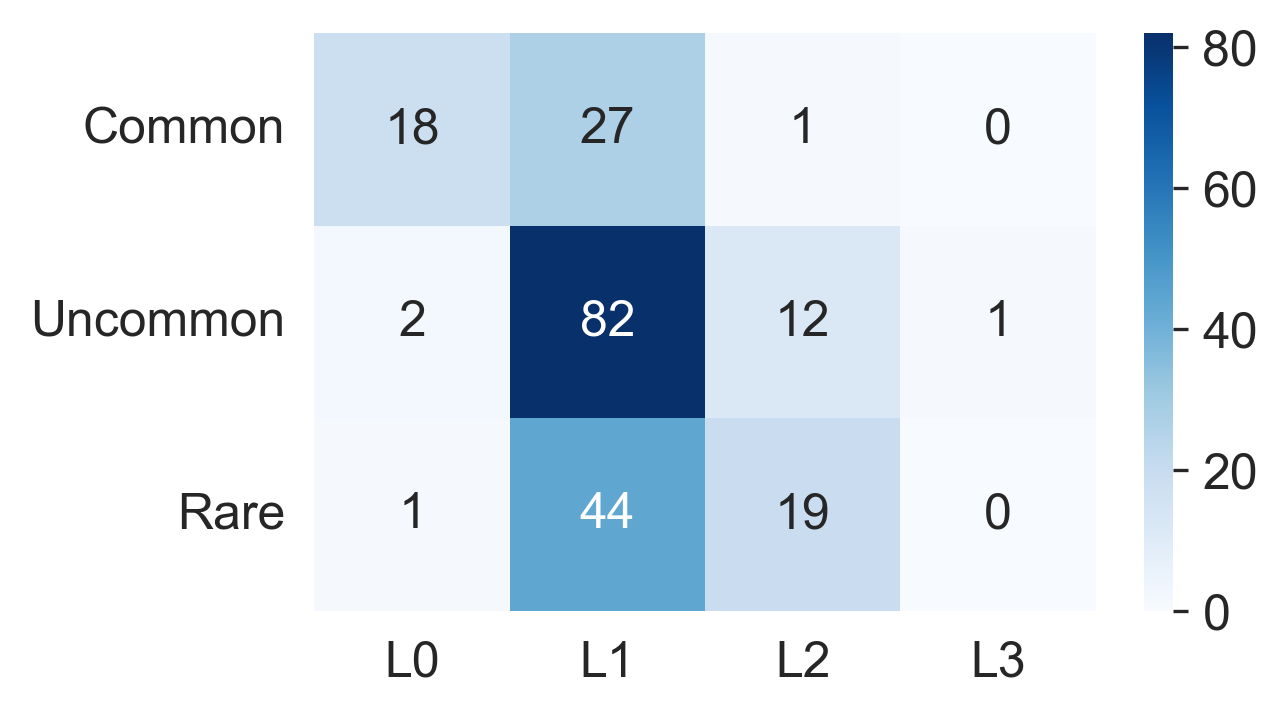

In [4]:
cat = rd.groupby('Type')['level'].value_counts().reset_index()
cat['level'] = 'L' + cat['level'].astype(str)
cat['Type'] = pd.Categorical(cat['Type'], ['Common','Uncommon','Rare'])
cat = pd.pivot_table(cat, index='Type', columns='level', values='count').fillna(0)

chi2, p, dof, expected = chi2_contingency(cat)
print(p)

plt.figure(figsize=(4*1.05, 2.5), dpi=300)
sns.set_style('white')

sns.heatmap(cat, cmap='Blues', vmin=0, annot=True, fmt=".0f")
a = plt.xticks(rotation=0, ha='center')
b = plt.yticks(rotation=0)

plt.xlabel('')
plt.ylabel('')

0.02117091361603918


Text(420.04166666666663, 0.5, '')

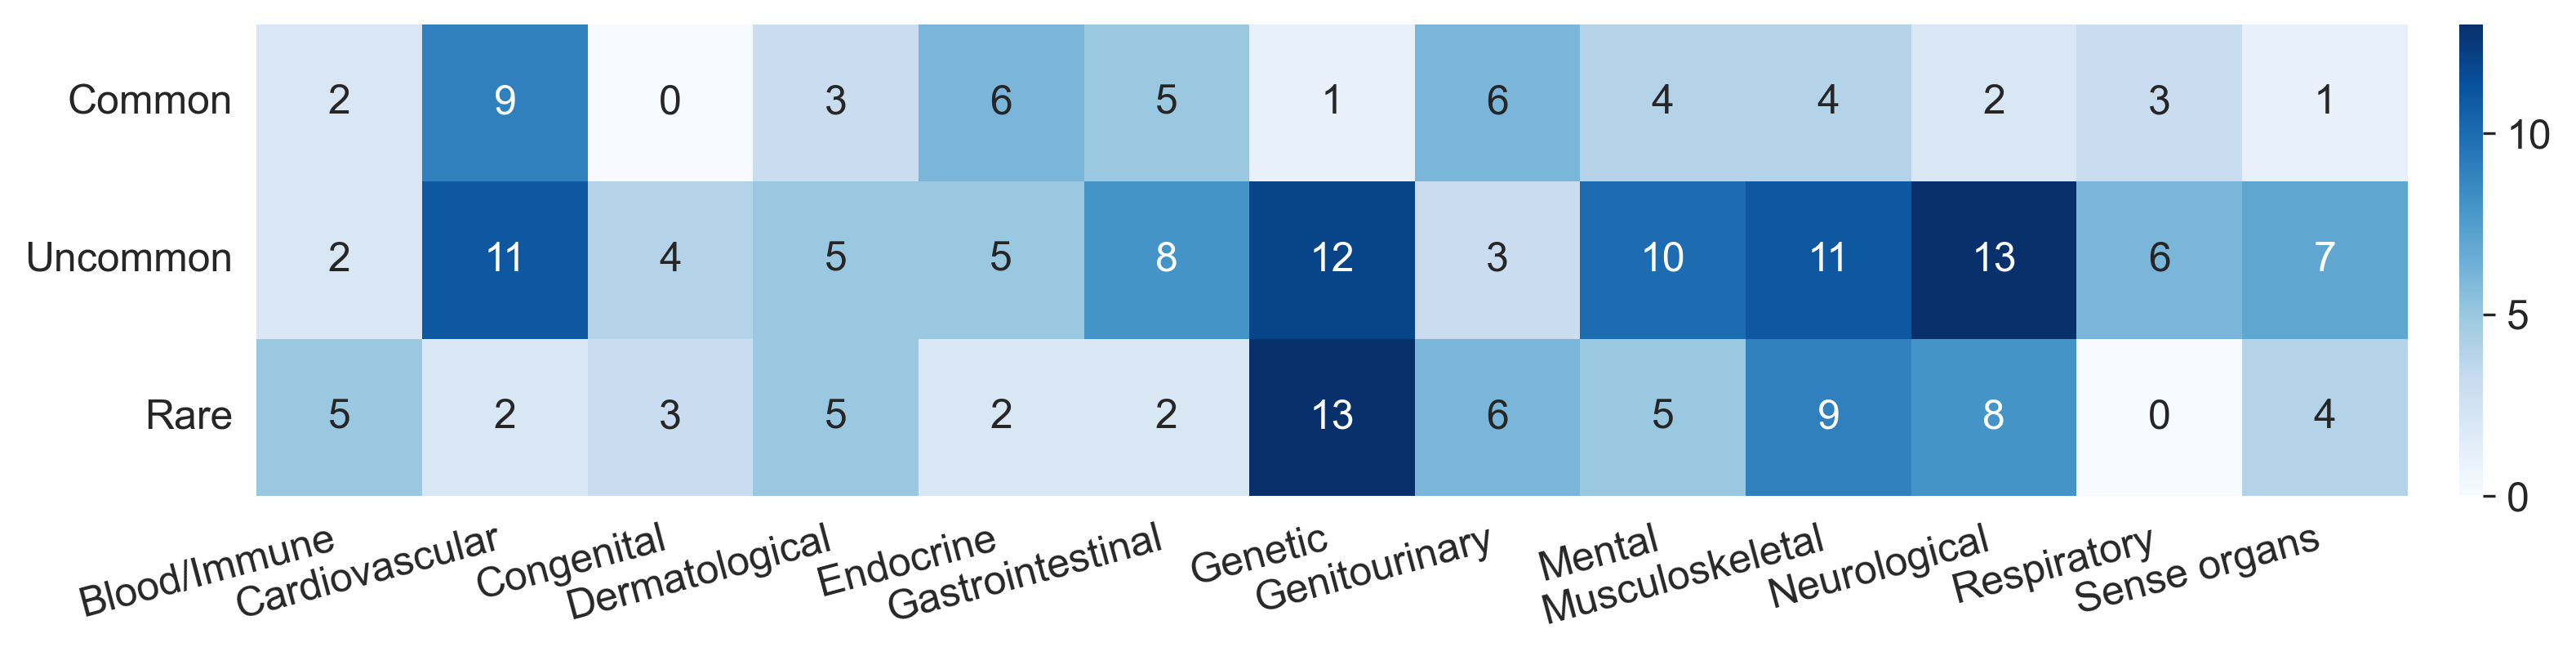

In [5]:
cat = rd.groupby('Type')['category'].value_counts().reset_index()
cat['category'] = cat['category'].str.replace('Muscloskeletal','Musculoskeletal')
cat['category'] = cat['category'].str.replace('Endocrine/Metab','Endocrine')
cat['Type'] = pd.Categorical(cat['Type'], ['Common','Uncommon','Rare'])
cat = pd.pivot_table(cat, index='Type', columns='category', values='count').fillna(0)

chi2, p, dof, expected = chi2_contingency(cat)
print(p)

plt.figure(figsize=(13*1.05, 2.5), dpi=300)
sns.set_style('white')

sns.heatmap(cat, cmap='Blues', vmin=0, annot=True, fmt=".0f", cbar_kws={'pad': 0.02})
a = plt.xticks(rotation=15, ha='right')
b = plt.yticks(rotation=0)

plt.xlabel('')
plt.ylabel('')

## Results (section 1)

In [25]:
ind = pd.read_pickle('./Final/drugs_ot.pkl')
ind['phase'] = ind['phase'].fillna(0)
ind.loc[(~ind['source'].astype(str).str.contains('OT|Minikel')) & (ind['phase'] != 0), 'phase'] = 0.25

ind['phecode_type'] = ind['phecode_type'].str.replace('Rare','Uncommon/Rare')
ind = ind.merge(rd[['phecode','Type']].rename({'Type':'rd_type'},axis=1))

clin = ['clin_ot','hgmd','omim']
somatic = ['cancer_gene_census','eva_somatic']

ind['binary_clinical'] = (ind[clin].sum(axis=1) > 0).astype(int)
ind['binary_l2g'] = (ind['gwas_credible_sets'] > 0).astype(int)
ind['binary_gb'] = (ind['gene_burden'] > 0).astype(int)
ind['binary_somatic'] = (ind[somatic].sum(axis=1) > 0).astype(int)
ind['binary_sysbio'] = (ind['reactome'] > 0).astype(int)
ind['binary_expression'] = (ind['expression_atlas'] > 0).astype(int)
ind['binary_impc'] = (ind['impc'] > 0).astype(int)


In [26]:
print('Number of indicated G-P pairs')
temp = ind.loc[ind['indication'] == 1]
print(temp['rd_type'].value_counts())
print(' ')
print('Number with evidence')
print(temp.loc[temp[['binary_clinical','binary_l2g','binary_gb','binary_somatic',
             'binary_sysbio','binary_expression','binary_impc']].max(axis=1) > 0]['rd_type'].value_counts())
print(' ')
print('Number with L2G or gene burden evidence')
print(temp.loc[temp[['binary_l2g','binary_gb']].max(axis=1) > 0]['rd_type'].value_counts())
print(' ')
print('Percent lacking evidence')
print(100-100*1524/8320)
print(100-100*416/4182)
print(100-100*197/1977)

Number of indicated G-P pairs
rd_type
Common      7740
Uncommon    3980
Rare        1932
Name: count, dtype: int64
 
Number with evidence
rd_type
Common      1701
Uncommon     399
Rare         195
Name: count, dtype: int64
 
Number with L2G or gene burden evidence
rd_type
Common      970
Uncommon     83
Rare         10
Name: count, dtype: int64
 
Percent lacking evidence
81.6826923076923
90.05260640841702
90.0354071825999


In [10]:
print(ind.groupby(['rd_type'])['indication'].sum())
print(' ')
print(ind.loc[ind['indication'] == 1].groupby('rd_type')['phecode'].nunique())
print(' ')
top_phecodes = ind.groupby('phecode')['indication'].sum().reset_index().merge(rd[['phecode','Type','phecode_string']])
print(top_phecodes.sort_values('indication', ascending=False)[:5])
print(top_phecodes.loc[top_phecodes['Type'] != 'Common'].sort_values('indication', ascending=False)[:5])
print(' ')
print(len(ind.loc[(ind['indication'] == 1) & (ind['gwas_credible_sets'] == 0) & 
        (ind['gene_burden'] == 0) & (ind['phecode_type'] == 'Uncommon/Rare')]))

rd_type
Common      7740
Rare        1932
Uncommon    3980
Name: indication, dtype: int64
 
rd_type
Common      46
Rare        42
Uncommon    70
Name: phecode, dtype: int64
 
      phecode  indication    Type  \
52   EM_202.2         566  Common   
111  GU_582.2         560  Common   
18     CV_404         552  Common   
28     CV_436         538  Common   
26     CV_431         426  Common   

                                     phecode_string  
52                                  Type 2 diabetes  
111                          Chronic kidney disease  
18                           Ischemic heart disease  
28                          Atherosclerosis [ASCVD]  
26   Stroke and transient cerebral ischemic attacks  
      phecode  indication      Type                 phecode_string
105  GU_580.1         376  Uncommon       Acute nephritic syndrome
27   CV_433.3         367  Uncommon  Cerebrovascular insufficiency
163  NS_323.3         324  Uncommon           Motor neuron disease
70   GE_97

rd_type
Uncommon    97
Rare        64
Common      46
Name: count, dtype: int64


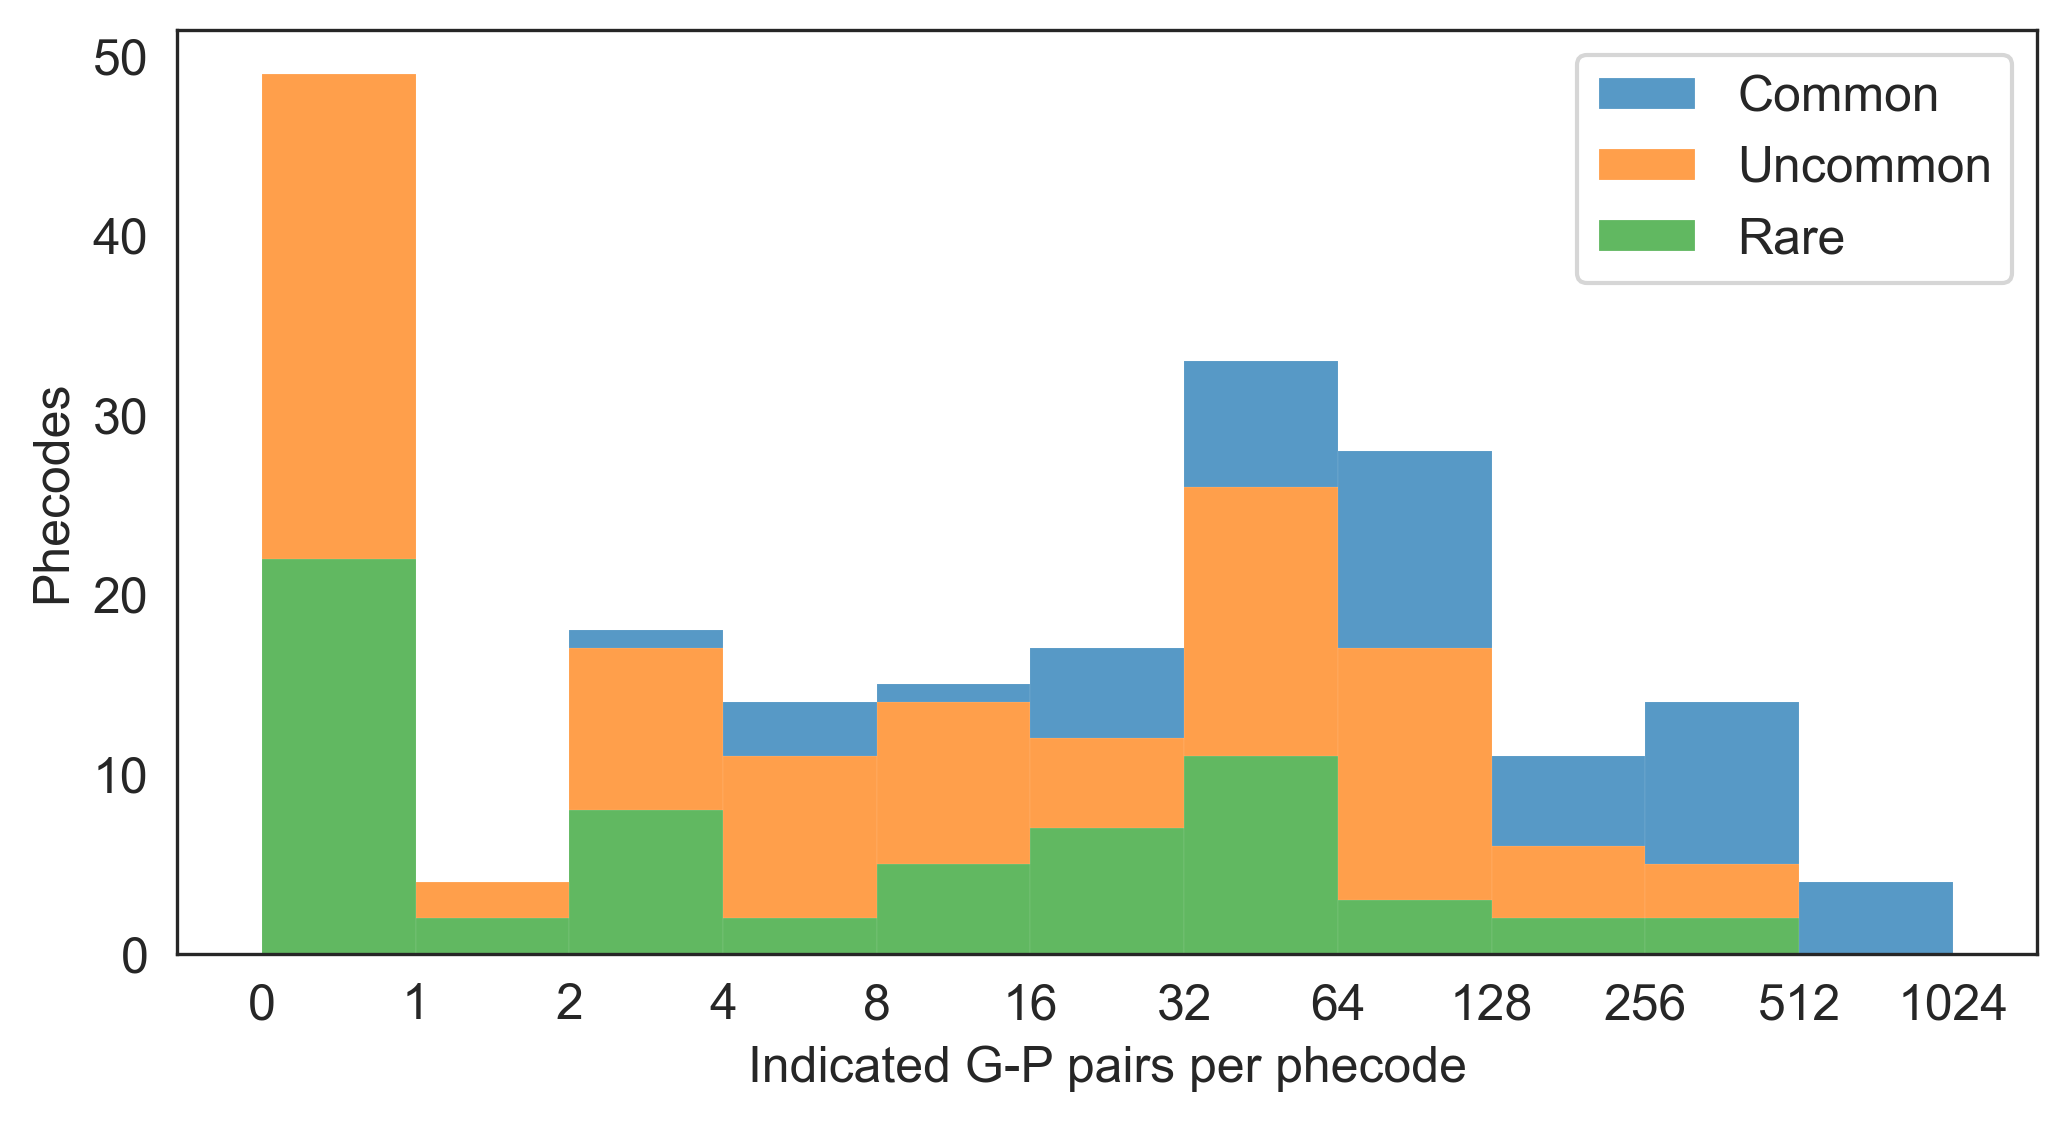

In [11]:
plt.figure(figsize=(8,4), dpi=300)

cpp = ind.groupby(['rd_type','phecode'])['indication'].sum().reset_index()
cpp.loc[cpp['indication'] == 0, 'indication'] = 0.51
cpp['rd_type'] = pd.Categorical(cpp['rd_type'], ['Common','Uncommon','Rare'])

print(cpp.loc[cpp['indication'] >= 0]['rd_type'].value_counts())
#print(cpp.merge(rd[['phecode','phecode_string']]).sort_values('indication',ascending=False)[:5])
bins = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
bin_labels = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

cpp = cpp.rename({'rd_type':'Phecode type'}, axis=1)
sns.histplot(cpp, x='indication', hue='Phecode type', bins=bins, multiple='stack')
plt.xscale('log', base=2)
tick = plt.xticks(ticks=bins, labels=[str(b) for b in bin_labels])
plt.xlabel('Indicated G-P pairs per phecode')
plt.ylabel('Phecodes')

legend = plt.gca().get_legend()
legend.set_title("")
plt.show()


0.018478417487476195
0.002314582185270774
0.0005385706261901983
1.190363335823265e-09


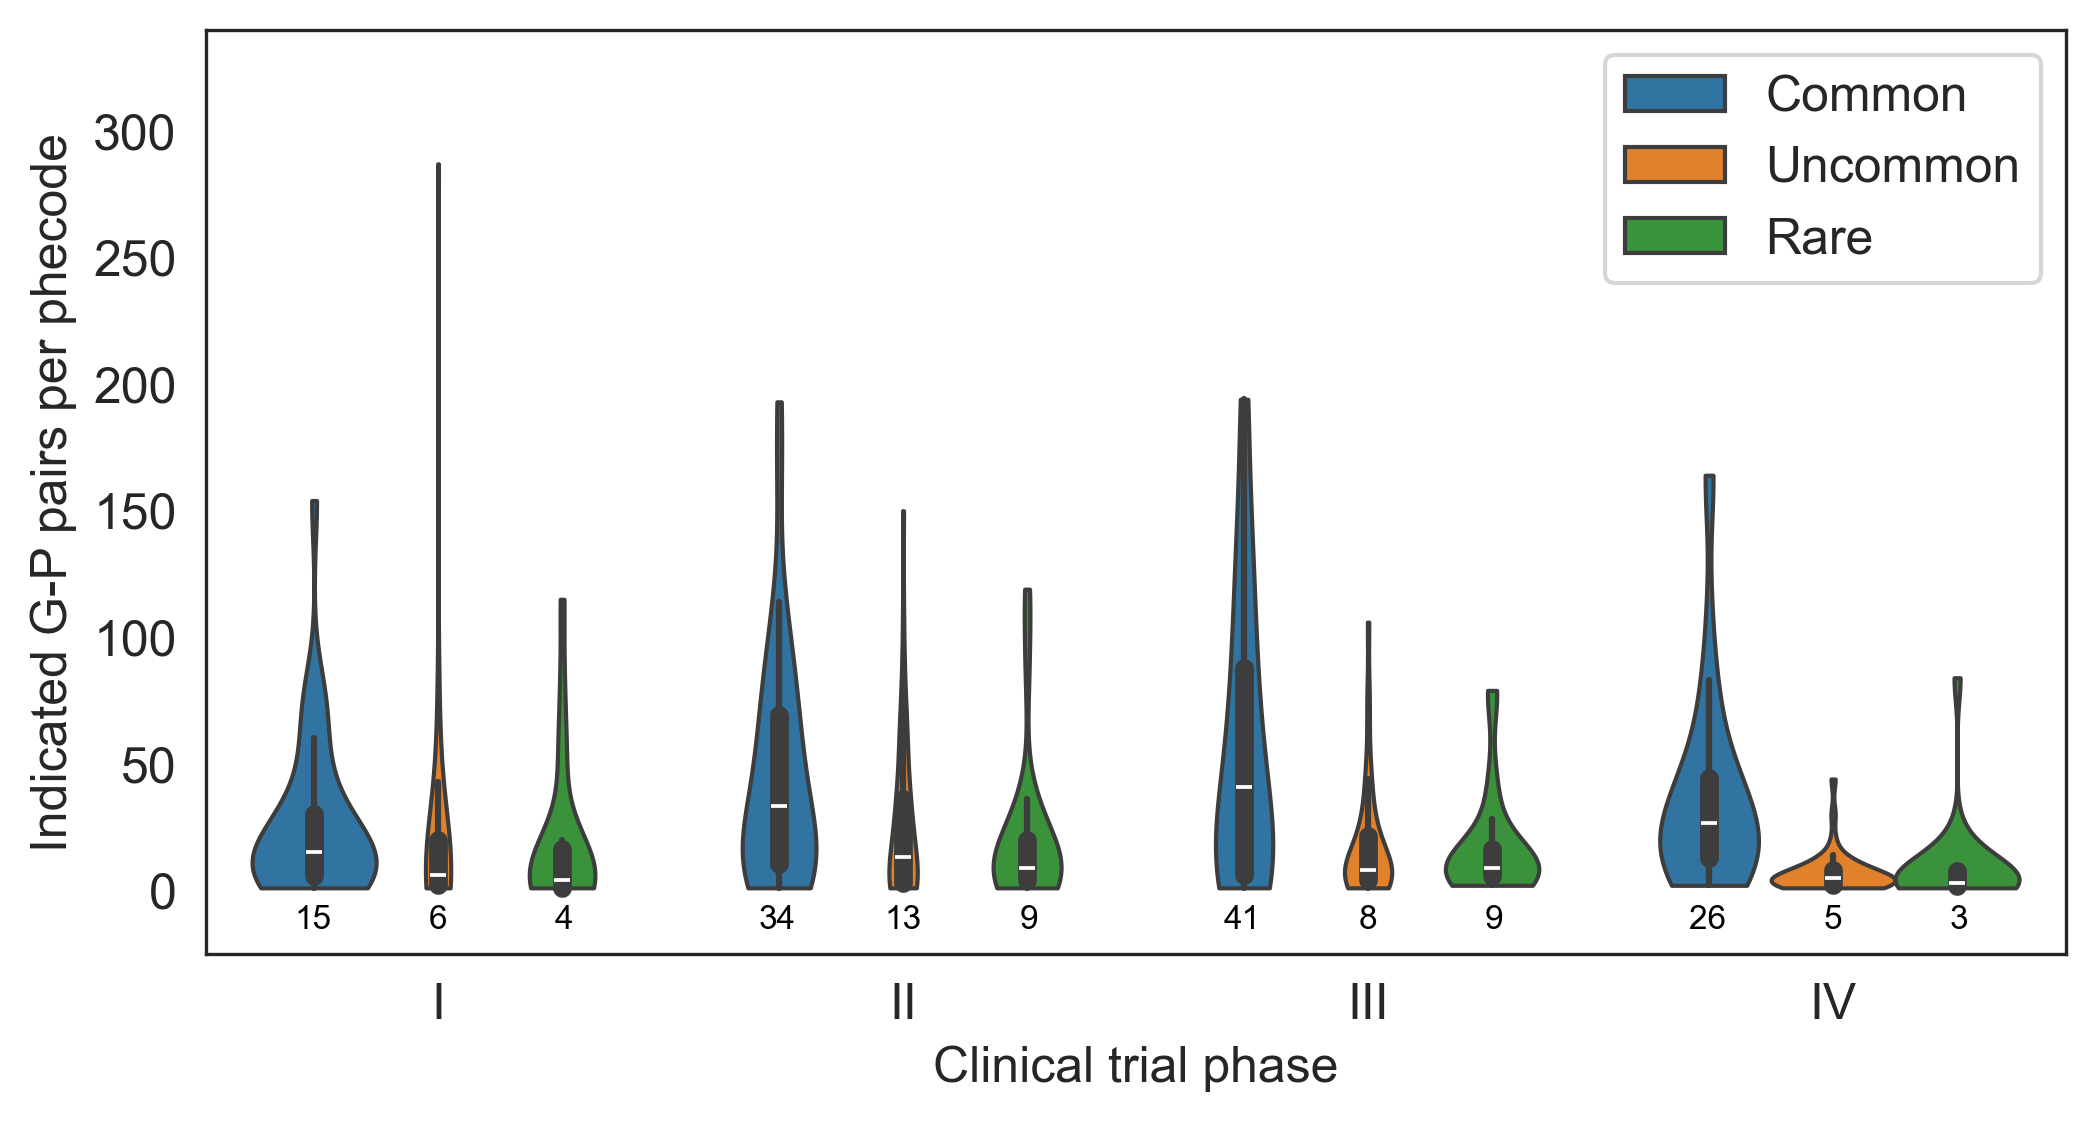

In [12]:
plt.figure(figsize=(8,4), dpi=300)

counts = ind.groupby(['rd_type','phecode'])['phase'].value_counts().reset_index()
counts = counts.loc[counts['phase'].isin([1,2,3,4])]
counts['rd_type'] = pd.Categorical(counts['rd_type'], ['Common','Uncommon','Rare'])
counts = counts.sort_values('phase')

for phase in [1,2,3,4]:
    temp = counts.loc[counts['phase'] == phase]
    a = temp.loc[temp['rd_type'] == 'Common']['count'].to_list()
    b = temp.loc[temp['rd_type'].isin(['Uncommon','Rare'])]['count'].to_list()
    print(ranksums(a,b)[1])

sns.violinplot(counts, x='phase', y='count', hue='rd_type', cut=0, linewidth=1)
plt.xlabel('Clinical trial phase')
plt.ylabel('Indicated G-P pairs per phecode')
dl = ['I','II','III','IV']
plt.xticks(np.arange(4), dl, rotation=0, ha='center')

# Calculate and plot medians
for phase in counts['phase'].unique():
    for rd_type in counts['rd_type'].unique():
        median_val = counts.loc[(counts['phase'] == phase) & (counts['rd_type'] == rd_type), 'count'].median()
        if not np.isnan(median_val):  # Only plot if there's a valid median
            x_coord = counts['phase'].unique().tolist().index(phase) + 0.27 * (['Common', 'Uncommon', 'Rare'].index(rd_type) - 1)
            plt.text(x_coord, -15, f'{median_val:.0f}', ha='center', fontsize=8, color='black')

plt.ylim([-25,340])

legend = plt.gca().get_legend()
legend.set_title("")
plt.show()


In [13]:
counts = ind.groupby(['rd_type','phecode'])[['binary_clinical','binary_l2g','binary_gb',
                                                'binary_somatic','binary_sysbio','binary_expression',
                                                'binary_impc']].sum().reset_index()
counts['rd_type'] = pd.Categorical(counts['rd_type'], ['Common','Uncommon','Rare'])
counts = pd.melt(counts, id_vars=['rd_type','phecode'])
counts['any'] = 0
counts.loc[counts['value'] > 0, 'any'] = 1

In [14]:
pval = counts.copy()
pval['rd_type'] = pval['rd_type'].astype(str)
pval.loc[pval['rd_type'].isin(['Uncommon','Rare']), 'rd_type'] = 'Uncommon/Rare'
pval = pval.groupby(['rd_type','variable'])['any'].value_counts().reset_index()
pval['any'] = pval['any'].map({0:'No',1:'Yes'})
pval = pd.pivot_table(pval, index=['rd_type','variable'], columns='any', values='count').reset_index()

results = []

for var in pval['variable'].unique():
    subset = pval.loc[pval['variable'] == var]
    common = subset[subset['rd_type'] == 'Common']
    uncommon_rare = subset[subset['rd_type'] == 'Uncommon/Rare']
    count_common = common['Yes'].sum()
    nobs_common = common[['No', 'Yes']].sum().sum()
    count_uncommon_rare = uncommon_rare['Yes'].sum()
    nobs_uncommon_rare = uncommon_rare[['No', 'Yes']].sum().sum()
    count = [count_common, count_uncommon_rare]
    nobs = [nobs_common, nobs_uncommon_rare]
    stat, p = proportions_ztest(count, nobs)
    results.append((var, stat, p))

df = pd.DataFrame(results, columns=['variable', 'z', 'p'])
df


,variable,z,p
0,binary_clinical,1.996384,4.589210e-02
1,binary_expression,4.602678,4.170925e-06
2,binary_gb,7.571298,3.695132e-14
3,binary_impc,-0.717440,4.731029e-01
4,binary_l2g,5.387587,7.141002e-08
5,binary_somatic,2.456715,1.402140e-02
6,binary_sysbio,0.761169,4.465564e-01


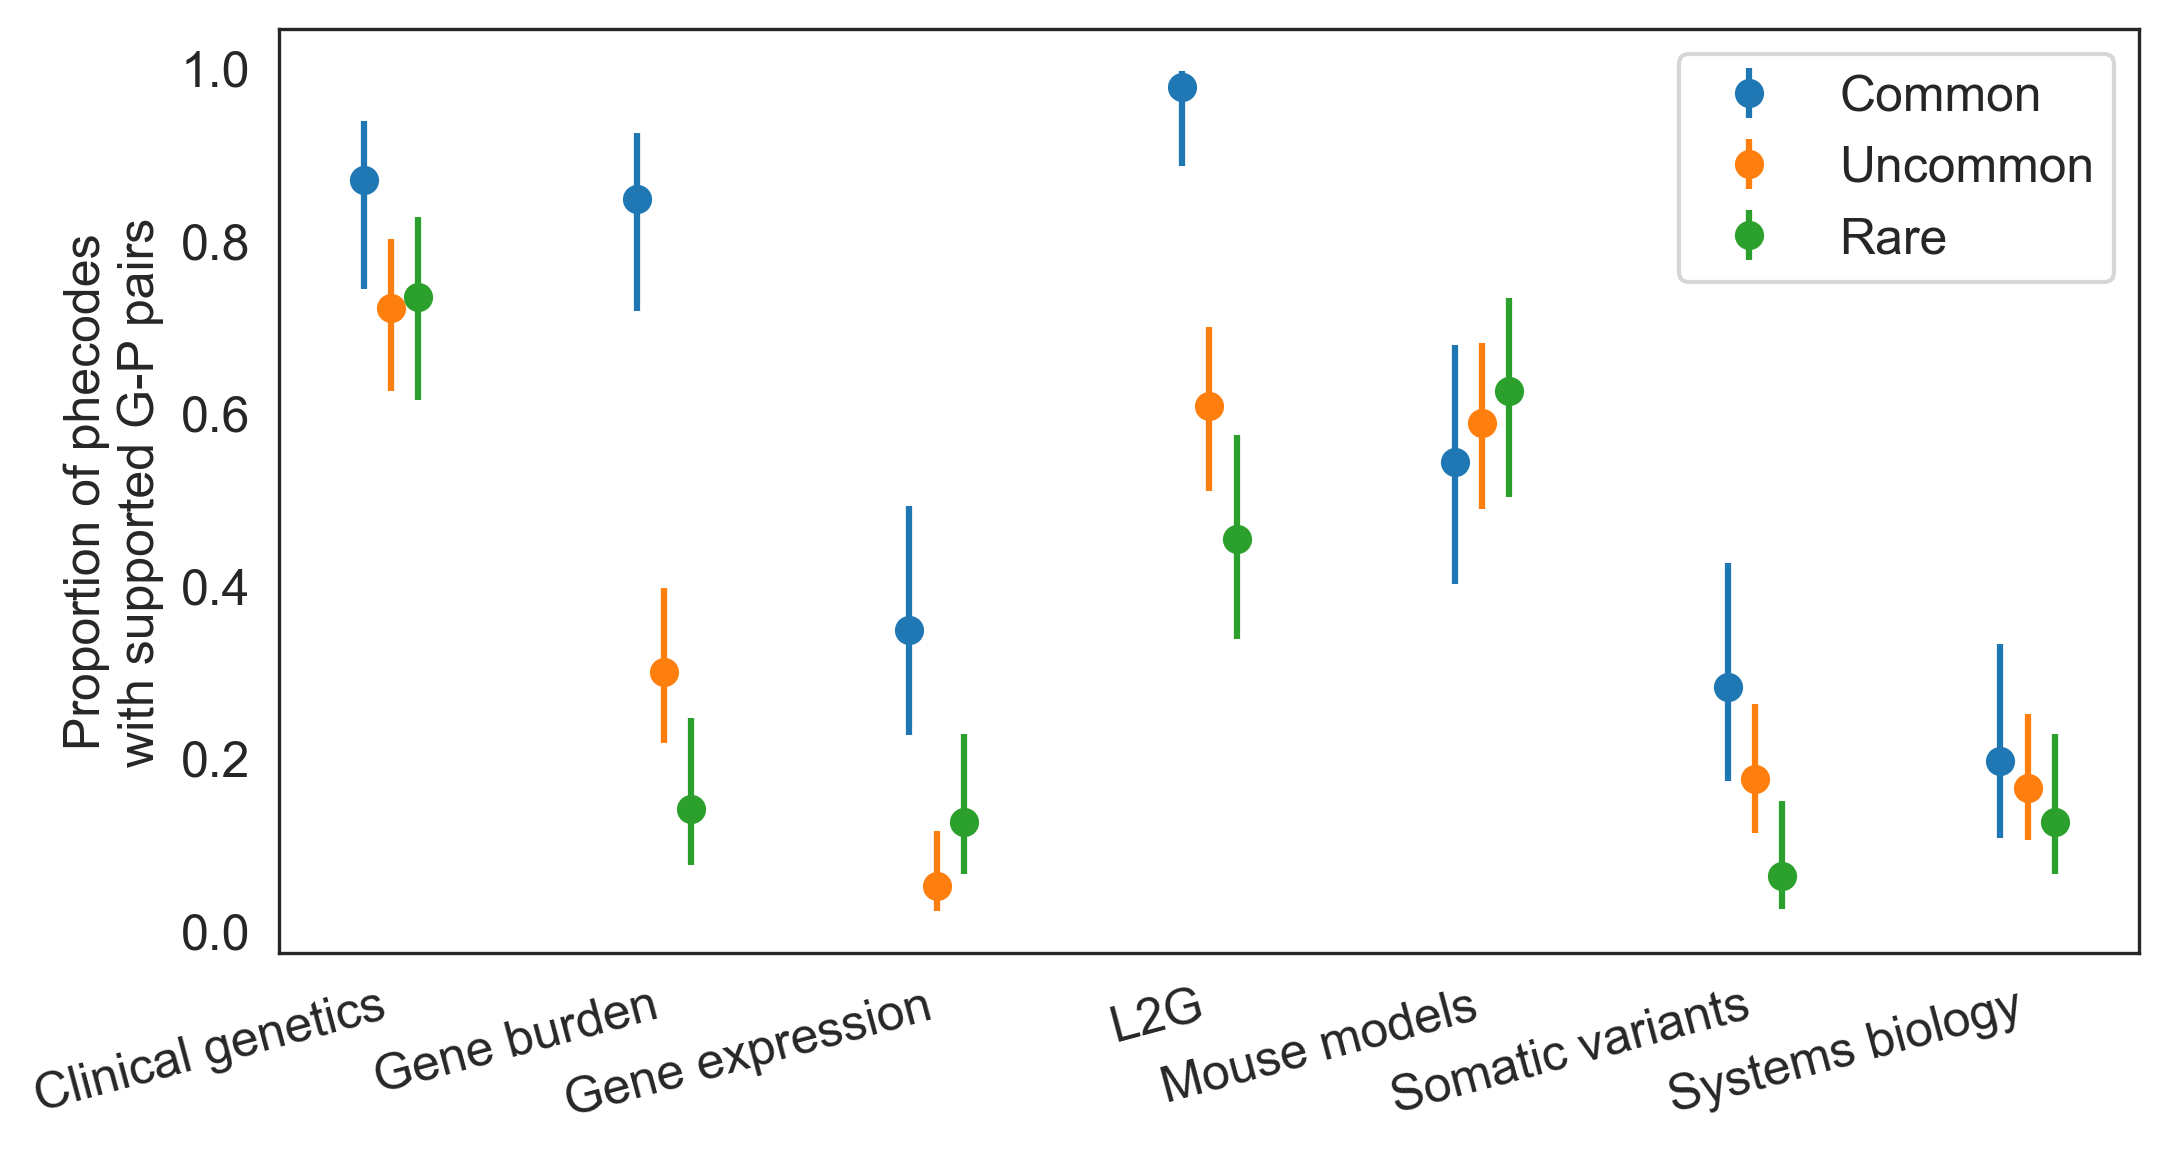

In [16]:
any = counts.groupby(['rd_type','variable'])['any'].apply(lambda x: pd.Series({
            'mean': x.mean(),
            'lower_95': proportion_confint(count=x.sum(), nobs=len(x), method='wilson')[0],
            'upper_95': proportion_confint(count=x.sum(), nobs=len(x), method='wilson')[1]
        })).reset_index()
any = pd.pivot_table(any, index=['rd_type','variable'], columns='level_2', values='any').reset_index()
any['variable'] = any['variable'].str.replace('binary_','').map({'clinical':'Clinical genetics','expression':'Gene expression',
                                                                'gb':'Gene burden','impc':'Mouse models','l2g':'L2G',
                                                                'somatic':'Somatic variants','sysbio':'Systems biology'})
any = any.sort_values('variable')

#####

dodge_width = 0.1
phecode_types = any['rd_type'].unique()
offsets = np.linspace(-dodge_width, dodge_width, len(phecode_types))

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
sns.set_style('white')

for i, (key, grp) in enumerate(any.groupby('rd_type')):
    ax.errorbar(np.arange(len(grp['variable'])) + offsets[i], grp['mean'], 
                yerr=[grp['mean'] - grp['lower_95'], grp['upper_95'] - grp['mean']], 
                label=key, fmt='o')

plt.xticks(np.arange(len(any['variable'].unique())), any['variable'].unique())
plt.xlabel('')
plt.ylabel('Proportion of phecodes\nwith supported G-P pairs')
plt.legend(title='')
plt.xticks(rotation=15, ha='right')
plt.show()


In [17]:
counts = ind.loc[ind['indication'] == 1]
counts = counts[['rd_type','gene','phecode',
              'binary_clinical','binary_l2g','binary_gb',
              'binary_somatic','binary_sysbio','binary_expression','binary_impc']]
counts['rd_type'] = pd.Categorical(counts['rd_type'], ['Common','Uncommon','Rare'])
counts = pd.melt(counts, id_vars=['rd_type','gene','phecode'])


In [18]:
pval = counts.copy()
pval['rd_type'] = pval['rd_type'].astype(str)
pval.loc[pval['rd_type'].isin(['Uncommon','Rare']), 'rd_type'] = 'Uncommon/Rare'
pval = pval.groupby(['rd_type','variable'])['value'].value_counts().reset_index()
pval['value'] = pval['value'].map({0:'No',1:'Yes'})
pval = pd.pivot_table(pval, index=['rd_type','variable'], columns='value', values='count').reset_index()

results = []

for var in pval['variable'].unique():
    subset = pval.loc[pval['variable'] == var]
    common = subset[subset['rd_type'] == 'Common']
    uncommon_rare = subset[subset['rd_type'] == 'Uncommon/Rare']
    count_common = common['Yes'].sum()
    nobs_common = common[['No', 'Yes']].sum().sum()
    count_uncommon_rare = uncommon_rare['Yes'].sum()
    nobs_uncommon_rare = uncommon_rare[['No', 'Yes']].sum().sum()
    count = [count_common, count_uncommon_rare]
    nobs = [nobs_common, nobs_uncommon_rare]
    stat, p = proportions_ztest(count, nobs)
    results.append((var, stat, p))

df = pd.DataFrame(results, columns=['variable', 'z', 'p'])
df


,variable,z,p
0,binary_clinical,9.959230,2.298352e-23
1,binary_expression,8.103854,5.324514e-16
2,binary_gb,2.001010,4.539126e-02
3,binary_impc,-4.640404,3.477293e-06
4,binary_l2g,23.859852,8.002187e-126
5,binary_somatic,0.959840,3.371358e-01
6,binary_sysbio,-4.365955,1.265685e-05


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Clinical genetics'),
  Text(1, 0, 'Gene burden'),
  Text(2, 0, 'Gene expression'),
  Text(3, 0, 'L2G'),
  Text(4, 0, 'Mouse models'),
  Text(5, 0, 'Somatic variants'),
  Text(6, 0, 'Systems biology')])

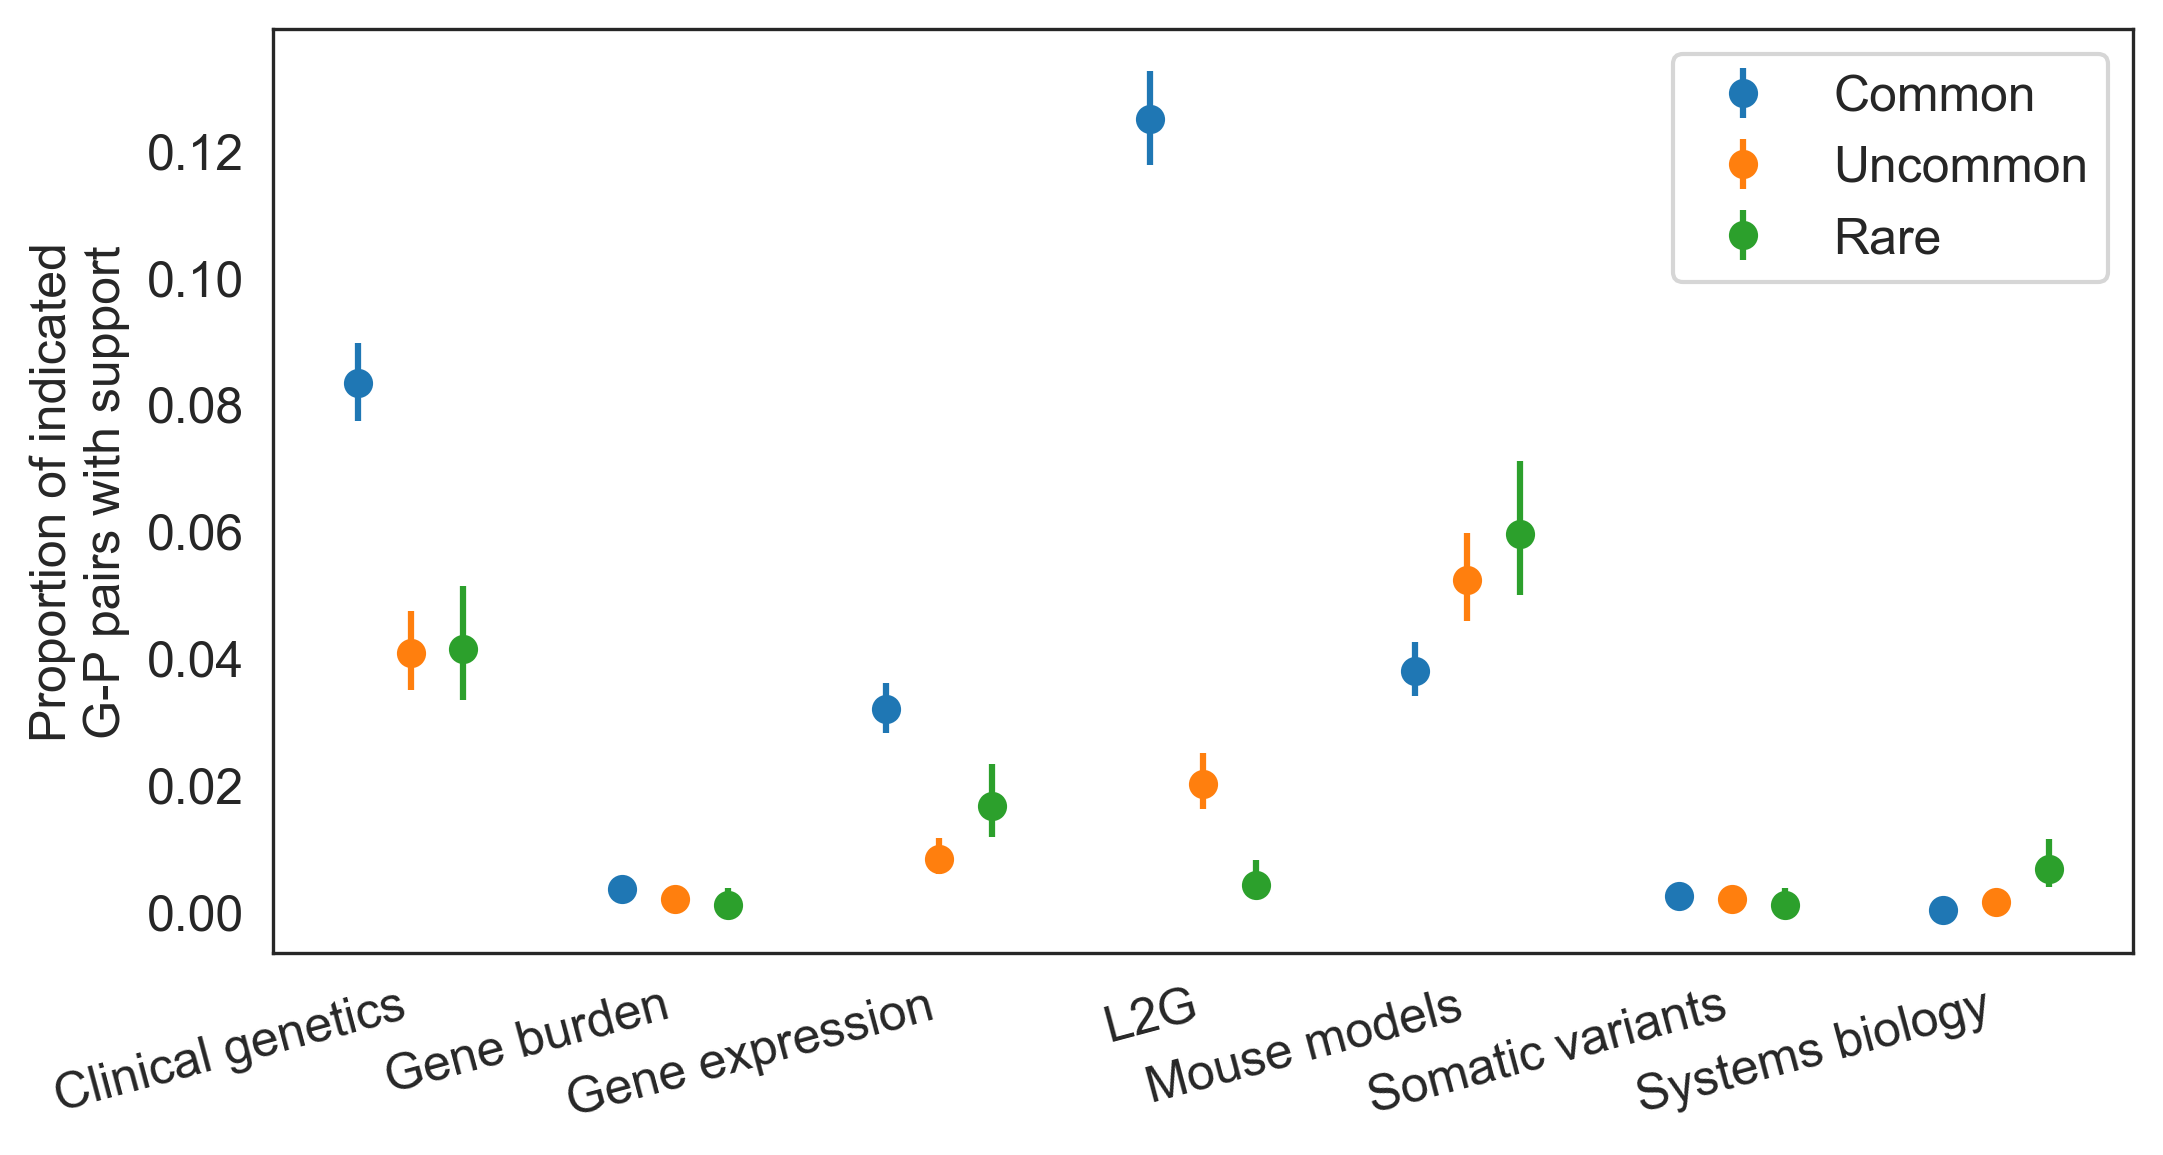

In [19]:
any = counts.groupby(['rd_type','variable'])['value'].apply(lambda x: pd.Series({
            'mean': x.mean(),
            'lower_95': proportion_confint(count=x.sum(), nobs=len(x), method='wilson')[0],
            'upper_95': proportion_confint(count=x.sum(), nobs=len(x), method='wilson')[1]
        })).reset_index()

any = pd.pivot_table(any, index=['rd_type','variable'], columns='level_2', values='value').reset_index()
any['variable'] = any['variable'].str.replace('binary_','').map({'clinical':'Clinical genetics','expression':'Gene expression',
                                                                'gb':'Gene burden','impc':'Mouse models','l2g':'L2G',
                                                                'somatic':'Somatic variants','sysbio':'Systems biology'})
any = any.sort_values('variable')

#####

dodge_width = 0.2
phecode_types = any['rd_type'].unique()
offsets = np.linspace(-dodge_width, dodge_width, len(phecode_types))

fig, ax = plt.subplots(figsize=(8,4), dpi=300)

for i, (key, grp) in enumerate(any.groupby('rd_type')):
    ax.errorbar(np.arange(len(grp['variable'])) + offsets[i], grp['mean'], 
                yerr=[grp['mean'] - grp['lower_95'], grp['upper_95'] - grp['mean']], 
                label=key, fmt='o')

plt.xticks(np.arange(len(any['variable'].unique())), any['variable'].unique())
plt.xlabel('')
plt.ylabel('Proportion of indicated\nG-P pairs with support')
plt.legend(title='')
plt.xticks(rotation=15, ha='right')


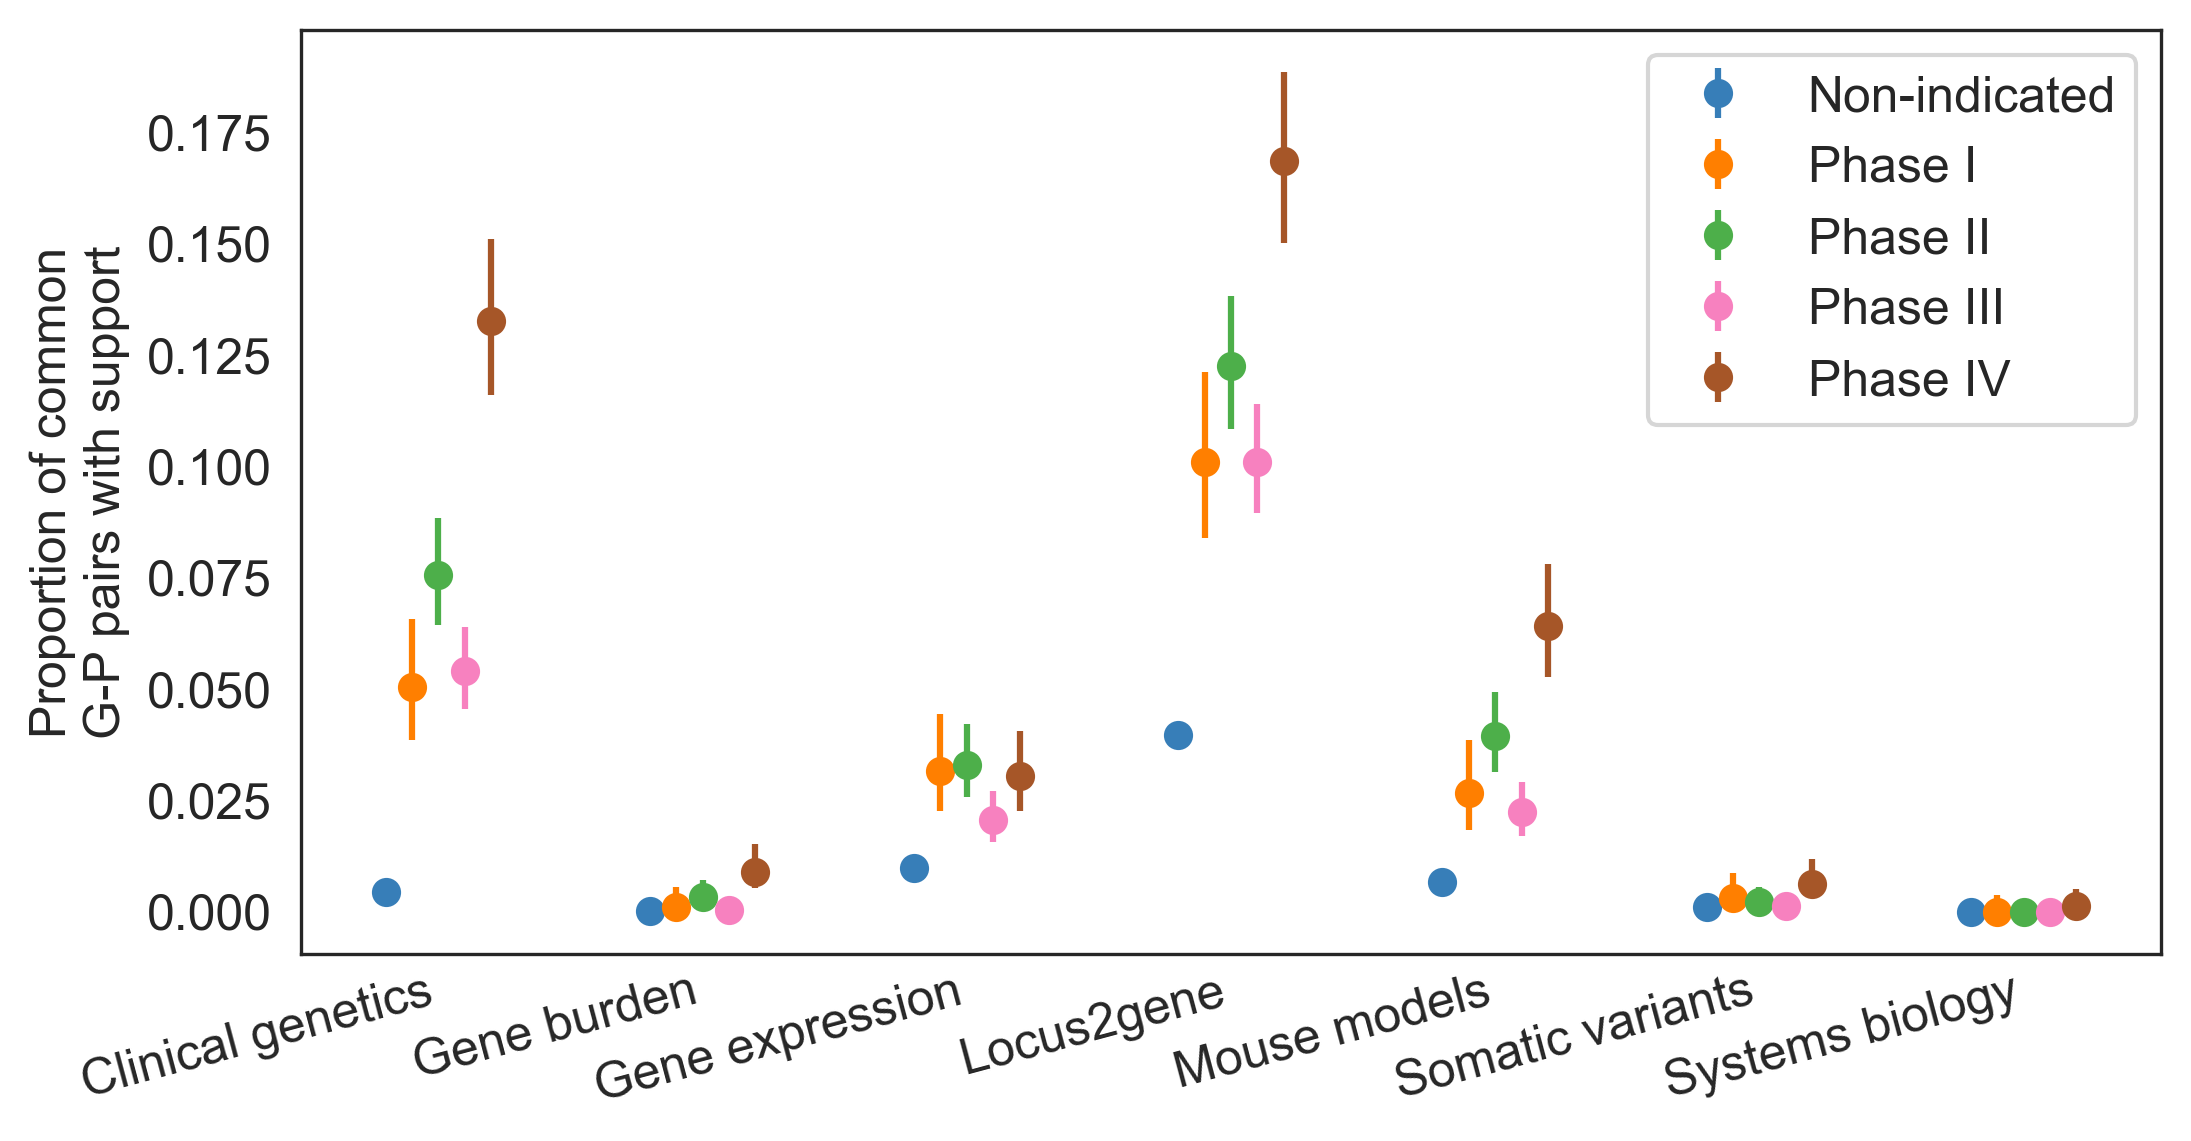

In [20]:
counts = ind[['phecode_type','phase','gene','phecode',
              'binary_clinical','binary_l2g','binary_gb',
              'binary_somatic','binary_sysbio','binary_expression','binary_impc']]
counts = pd.melt(counts, id_vars=['phecode_type','phase','gene','phecode'])

any = counts.groupby(['phecode_type','phase','variable'])['value'].apply(lambda x: pd.Series({
            'mean': x.mean(),
            'lower_95': proportion_confint(count=x.sum(), nobs=len(x), method='wilson')[0],
            'upper_95': proportion_confint(count=x.sum(), nobs=len(x), method='wilson')[1]
        })).reset_index()

any = pd.pivot_table(any, index=['phecode_type','phase','variable'], columns='level_3', values='value').reset_index()
any['variable'] = any['variable'].str.replace('binary_','').map({'clinical':'Clinical genetics','expression':'Gene expression',
                                                                'gb':'Gene burden','impc':'Mouse models','l2g':'Locus2gene',
                                                                'somatic':'Somatic variants','sysbio':'Systems biology'})

temp = any.loc[(any['phecode_type'] == 'Common') & (any['phase'].isin([0,1,2,3,4]))]
temp['phase'] = temp['phase'].astype(int)
temp['phase'] = temp['phase'].map({0:'Non-indicated',1:'Phase I',2:'Phase II',3:'Phase III',4:'Phase IV'})
temp = temp.sort_values('variable')

#####

dodge_width = 0.2
phecode_types = temp['phase'].unique()
offsets = np.linspace(-dodge_width, dodge_width, len(phecode_types))

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
sns.set_style('white')

for i, (key, grp) in enumerate(temp.groupby('phase')):
    lower_err = np.clip(grp['mean'] - grp['lower_95'], 0, None)
    upper_err = np.clip(grp['upper_95'] - grp['mean'], 0, None)
    ax.errorbar(np.arange(len(grp['variable'])) + offsets[i], grp['mean'], 
                yerr=[lower_err, upper_err], 
                label=key, fmt='o', color=CB_color_cycle[i])

plt.xticks(np.arange(len(temp['variable'].unique())), temp['variable'].unique())
plt.xlabel('')
plt.ylabel('Proportion of common\nG-P pairs with support')
plt.legend(title='')
plt.xticks(rotation=15, ha='right')
plt.gca().tick_params(axis='x', which='both', length=0)
plt.show()


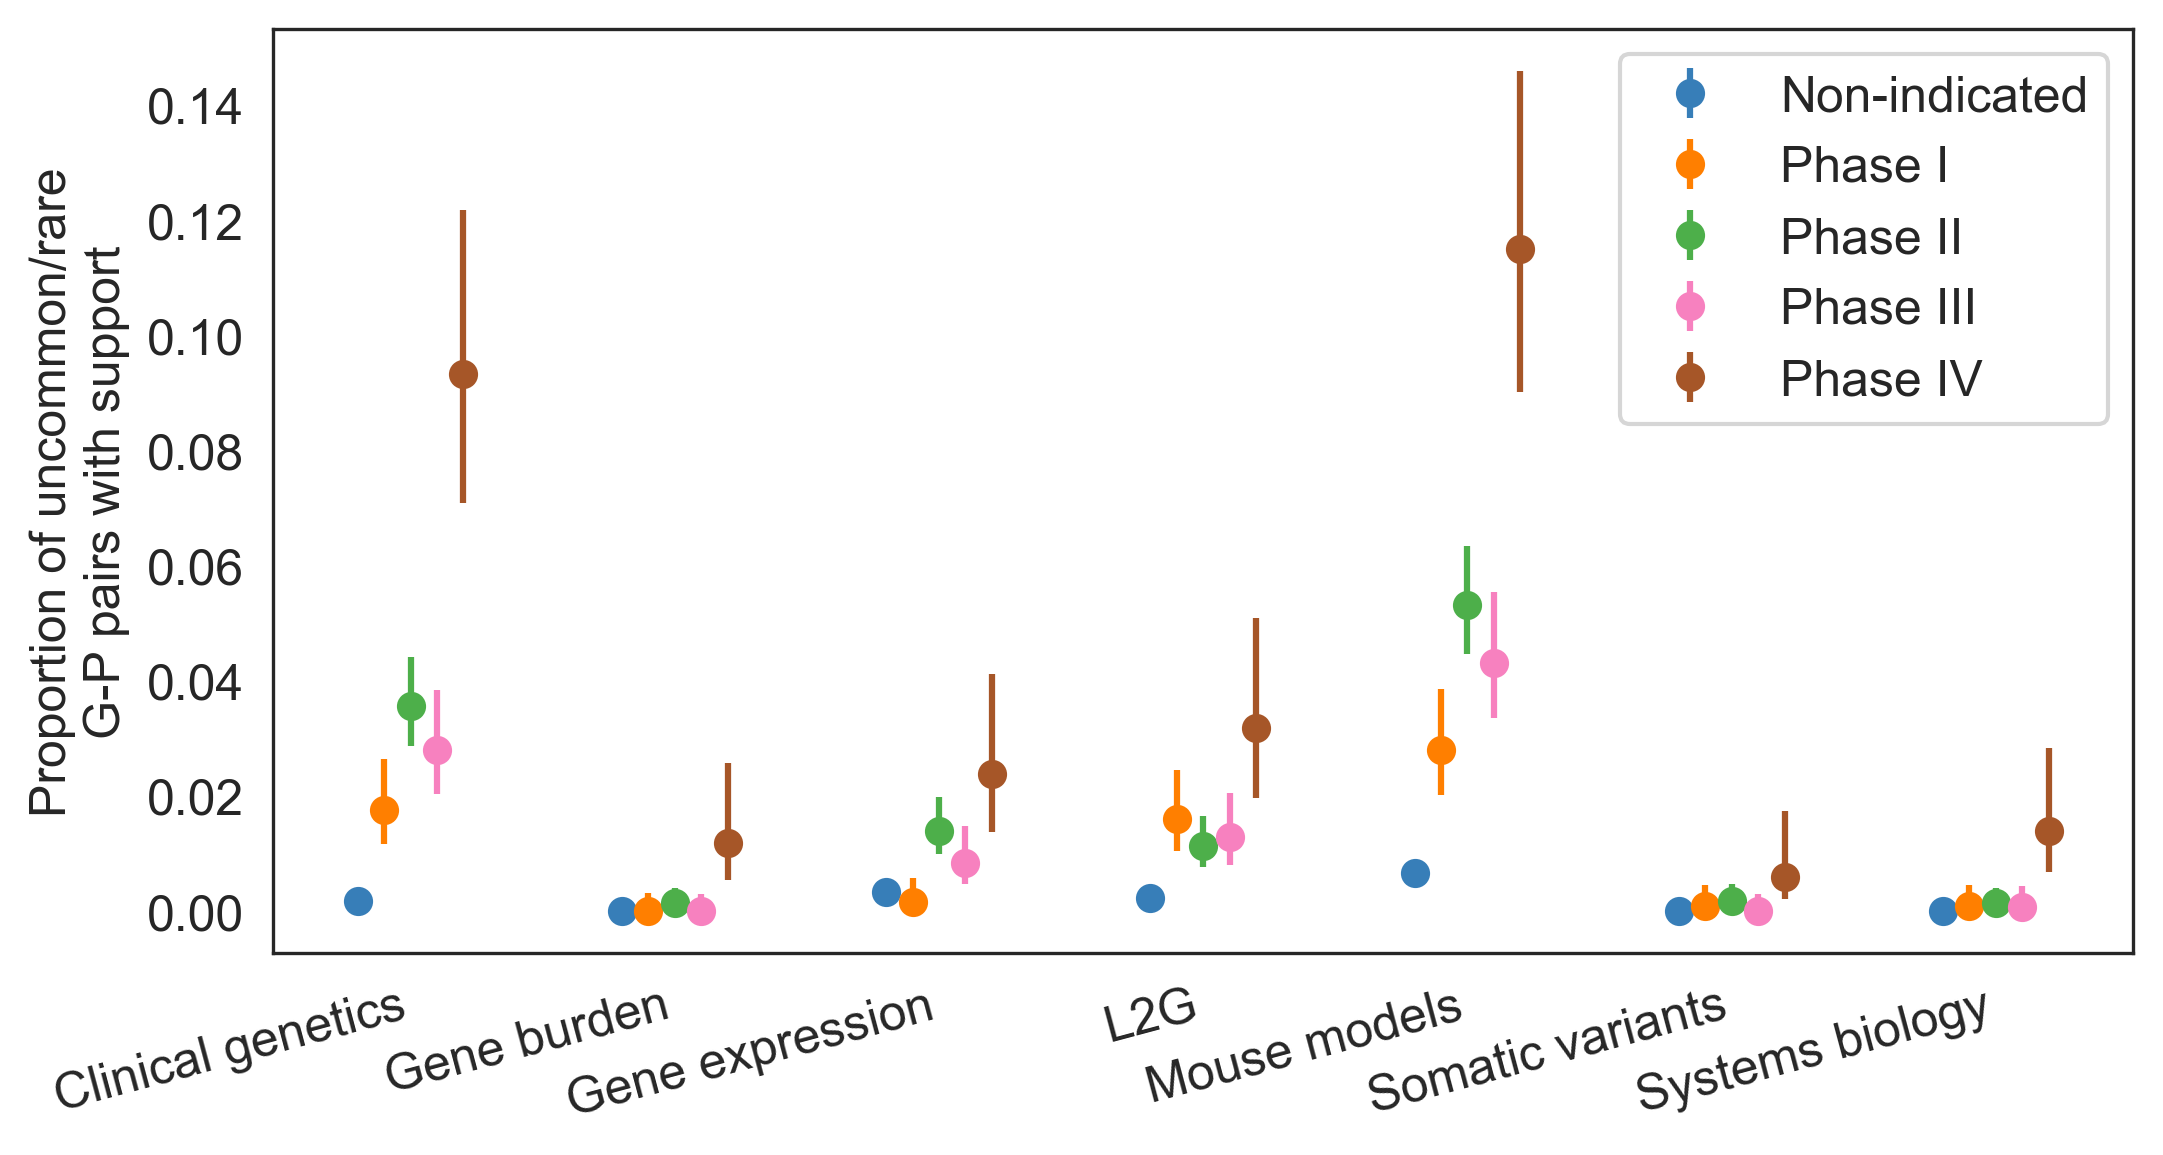

In [21]:
counts = ind[['phecode_type','phase','gene','phecode',
              'binary_clinical','binary_l2g','binary_gb',
              'binary_somatic','binary_sysbio','binary_expression','binary_impc']]
counts = pd.melt(counts, id_vars=['phecode_type','phase','gene','phecode'])

any = counts.groupby(['phecode_type','phase','variable'])['value'].apply(lambda x: pd.Series({
            'mean': x.mean(),
            'lower_95': proportion_confint(count=x.sum(), nobs=len(x), method='wilson')[0],
            'upper_95': proportion_confint(count=x.sum(), nobs=len(x), method='wilson')[1]
        })).reset_index()

any = pd.pivot_table(any, index=['phecode_type','phase','variable'], columns='level_3', values='value').reset_index()
any['variable'] = any['variable'].str.replace('binary_','').map({'clinical':'Clinical genetics','expression':'Gene expression',
                                                                'gb':'Gene burden','impc':'Mouse models','l2g':'L2G',
                                                                'somatic':'Somatic variants','sysbio':'Systems biology'})

temp = any.loc[(any['phecode_type'] == 'Uncommon/Rare') & (any['phase'].isin([0,1,2,3,4]))]
temp['phase'] = temp['phase'].astype(int)
temp['phase'] = temp['phase'].map({0:'Non-indicated',1:'Phase I',2:'Phase II',3:'Phase III',4:'Phase IV'})
temp = temp.sort_values(['variable','phase'])

#####

dodge_width = 0.2
phecode_types = temp['phase'].unique()
offsets = np.linspace(-dodge_width, dodge_width, len(phecode_types))

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
sns.set_style('white')

for i, (key, grp) in enumerate(temp.groupby('phase')):
    lower_error = np.maximum(grp['mean'] - grp['lower_95'], 0)
    upper_error = np.maximum(grp['upper_95'] - grp['mean'], 0)
    ax.errorbar(np.arange(len(grp['variable'])) + offsets[i],
                grp['mean'],
                yerr=[lower_error, upper_error],
                label=key, fmt='o', color=CB_color_cycle[i])

plt.xticks(np.arange(len(temp['variable'].unique())), temp['variable'].unique())
plt.xlabel('')
plt.ylabel('Proportion of uncommon/rare\nG-P pairs with support')
plt.legend(title='')
plt.xticks(rotation=15, ha='right')
plt.show()

